# Home Credit - Credit Risk Model Stability Project

## Abstract

The goal of this project is to accurately predict which clients are likely to default on their loans. Loan defaults pose significant financial risks to consumer finance providers, impacting their profitability and stability. Traditional methods of assessing default risk often rely on historical data and conventional credit scoring models, which may not fully capture the complexities of an individual's financial behavior over time. By leveraging advanced machine learning techniques, this project seeks to develop more reliable and robust models for predicting loan defaults.

This endeavor is crucial as it offers consumer finance providers a tool to better assess the risk associated with potential clients, leading to more informed lending decisions. Improved prediction models can help reduce the incidence of loan defaults, thereby enhancing the financial health of lending institutions. Additionally, stable and accurate risk assessments can contribute to fairer lending practices, as they are likely to identify creditworthy clients who might be overlooked by traditional methods. This project not only aims to enhance the accuracy of default predictions but also emphasizes the importance of model stability over time, ensuring that the solutions are sustainable and effective in the long run.

### Accomplishments:

1. Ability to work with highly imbalanced data and perform different types of missing value imputations to enhance model performance:
    A significant discovery during our investigation was the profound impact that missing value imputation had on model performance. Given that approximately 92% of our dataset contained missing values, robust imputation strategies were essential(mean and mode imputation, knn imputation, binary indicators) significantly improved the model's ability to handle incomplete data.
    This approach not only filled the gaps in the dataset but also provided additional signals that the model could leverage to make more accurate predictions.
2. Effectivenes of SMOTE in addressing class imbalance:
    By generating synthetic samples for the minority class, SMOTE significantly improved the recall of the minority class predictions without overly compromising precision. This balancing act was pivotal in ensuring that the model could identify true positives more reliably. Our iterative evaluation showed a substantial increase in the recall metric, indicating that the model became much better at identifying positive instances in the imbalanced dataset.

## Introduction

Our project aims to develop a robust model for predicting loan defaults using a highly imbalanced dataset from a Kaggle competition hosted by Home Credit ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview)). This dataset includes over 1.5 million cases with a binary target variable indicating default (positive class) or no default (negative class). The data spans various financial and socio-economic features, sourced from multiple tables, with a significant imbalance (97% no default, 3% default) and a high percentage of missing values (92%). The primary research question is: Can we create a stable, accurate predictive model that effectively identifies clients likely to default on loans?

### Importance and Research Plan
Predicting loan defaults accurately is crucial for financial institutions as it directly impacts their risk management strategies and financial stability. Improved prediction models can reduce financial losses and help institutions make more informed lending decisions, ultimately contributing to a healthier financial ecosystem.

#### Key Results

Key results include significant improvements in precision and recall metrics by using the LightGBM model. This demonstrates our model’s enhanced ability to identify true positive cases of loan defaults, despite the challenges posed by the dataset's imbalance and missing values.

## Background

## Data

As stated above, our dataset comes from the Kaggle Competition - Credit Risk Model Stability hosted by Home Credit, an international consumer finance provider. The data can be obtained by downloading from the Kaggle website ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data)) or entering the command line (install Kaggle first):
```bash
kaggle competitions download -c home-credit-credit-risk-model-stability
```

The dataset is spread across 17 tables (1 base table + 16 data tables). It is split between training data with over 1.5 million cases, and testing data with 10 cases and no target labels. Our training and testing sets were taken from the training data provided as the test set could not provide us with any evaluation metrics and was too small.

In [29]:
# Directory to data
data_root = '../data/raw/csv_files/train'

### Base Table

In [30]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization functions
import utils.viz_tools as viz_tools

warnings.filterwarnings('ignore')

In [31]:
base_table = 'train_base.csv'
base_df = pd.read_csv(os.path.join(data_root, base_table))
base_df['date_decision'] = pd.to_datetime(base_df['date_decision'])

With the base table we can inspect the composition of the classes. A class imbalance of 97-to-3 in favor of the negative case (no default) is a very imbalanced dataset.

In [32]:
# Total cases
n_total = len(base_df)

# Number of negative cases
n_neg = len(base_df[base_df['target'] == 0])

# Number of positive cases
n_pos = len(base_df[base_df['target'] == 1])

print('Number of total cases:', n_total)
print(f'Negative cases: Count - {n_neg}, Percentage - {100*n_neg/n_total:.2f}%')
print(f'Positive cases: Count - {n_pos}, Percentage - {100*n_pos/n_total:.2f}%')

Number of total cases: 1526659
Negative cases: Count - 1478665, Percentage - 96.86%
Positive cases: Count - 47994, Percentage - 3.14%


The base table also contained another very relevant feature, `date_decision`. As we are trying to predict *future* applicant cases, the test set must be taken from the latest decision dates.

The `date_decision` also contains trends on how often cases default.

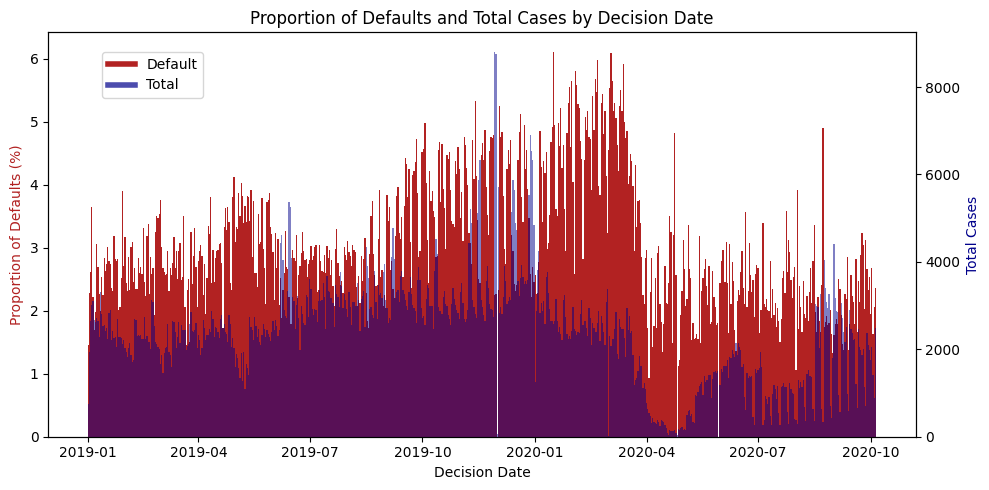

In [33]:
# Get proportion of defaults by date
date_target_prop = base_df.groupby('date_decision')['target'].value_counts(normalize=True).reset_index()
date_target_prop = date_target_prop[date_target_prop['target'] == 1]
date_target_prop['proportion'] = 100 * date_target_prop['proportion']

# Get number of decisions by date
date_total = base_df.groupby('date_decision')['target'].count().reset_index()

# Plot
viz_tools.two_bars_share_x(df1=date_target_prop, df2=date_total,
                          x_name='date_decision', y1_name='proportion',
                          y2_name='target', x_label='Decision Date',
                          title='Proportion of Defaults and Total Cases by Decision Date',
                          y1_label='Proportion of Defaults (%)',
                          y2_label='Total Cases', l1_label='Default',
                          l2_label='Total')

### Data Tables

We have 16 data tables containing static and transactional data stored as categorical data, numerical data, and dates. These tables are further broken down into 3 different depths.

- Depth 0 tables are indexed by the `case_id` alone and primarily include static data such as date of birth.
- Depth 1 tables are indexed by `case_id` and `num_group1` and contain historical data and possible associated parties.
- Depth 2 tables are index by `case_id`, `num_group1`, and `num_group2` while also containing historical data and possible associated parties.

![Tables](figures/tables.jpg)

Of particular note, when `num_group1` is equal to *0*, the data is directly associated with the current applicant of the loan.

In order to predict by case, we needed to aggregate data by `case_id` in the depth 1 and depth 2 tables.

### Data Preprocessing

We separated the data by the current applicant data and non-current applicant data (`num_group1` is not equal to *0*). From there, we applied multiple different aggregations grouping by `case_id`.

- Categorical: we retrieved the mode and applied both binary encoding to reduce the number of columns (versus one-hot encoding) and frequency encoding, to indicate the frequency of the category.
- Numerical: mean, min, max, median, and sum.
- Date: min, max, and number of distinct dates.

![Aggs](figures/aggs.jpg)

From the aggregated data, we decided to subsample the dataset for the training data where the minority class (default) was weighted more heavily at a ratio of 5-to-1.  Additionally, the test set was a holdout of the last cases in the dataset, as stated, in order to get a prediction on *future* cases.

In [34]:
import utils.merge_tools as merge_tools

In [35]:
data_dir = '../data/processed/grouped/new_aggs/'
base_file = '../data/raw/csv_files/train/train_base.csv'

n_cases = 15000

# Merging all data tables to base table
train_set, test_set = merge_tools.merge_n_case_ids(
    n_ids=n_cases,
    data_dir=data_dir,
    path_to_base=base_file,
    test_size=0.2, 
    random_state=28
)

# Drop redundant columns
drop_cols = ['MONTH', 'WEEK_NUM', 'date_decision_right', 'MONTH_right', 'WEEK_NUM_right']
train_set = train_set.drop(columns=drop_cols)
test_set = test_set.drop(columns=drop_cols)

# Sort cases by decision date in train set
train_set = train_set.sort_values('date_decision')

We have a train/test ratio of 4:1.

In [36]:
print('Size of training set:', len(train_set))
print('Size of testing set:', len(test_set))

Size of training set: 12000
Size of testing set: 3000


In [37]:
pct_null = train_set.isnull().sum().sum() / (len(train_set)*(len(train_set.columns)-1))
print(f'Percentage of missing values in aggregated data: {100*pct_null:.2f}%')

Percentage of missing values in aggregated data: 55.84%


The proportion of classes in the training set:

In [38]:
train_set['target'].value_counts(normalize=True)

target
0    0.862083
1    0.137917
Name: proportion, dtype: float64

The proportion of classes in the testing set:

In [39]:
test_set['target'].value_counts(normalize=True)

target
0    0.977333
1    0.022667
Name: proportion, dtype: float64

## Methods

### Extra data cleaning

We futher clean the data to be able to feed the previously stated predictors.
 - Boolean Columns:
The boolean columns are filled with False where None is present, and then converted to boolean type using .astype(bool).
- Object Columns:
The object columns, which contain None, True, or False, are replaced with np.nan, 1.0, or 0.0 respectively, and converted to float.

In [40]:
# Convert date_decision to timestamp
train_set['date_decision'] = pd.to_datetime(train_set["date_decision"]).astype('int64') / 10**9
test_set['date_decision'] = pd.to_datetime(test_set["date_decision"]).astype('int64') / 10**9

# Get boolean columns from df_full
# bool_columns = train_set.select_dtypes(include=['bool']).columns.tolist()

# for col in bool_columns:
#     train_set[col] = train_set[col].fillna(False).astype(bool)
#     test_set[col] = test_set[col].fillna(False).astype(bool)

### Missing Values

In [41]:
# Create missing value count DataFrame
null_df = train_set.copy()
null_df['total_null'] = train_set.isna().sum(axis=1)
null_df = null_df[['target', 'total_null']]

n_bins = 10

# Bin values by total missing values in row
null_df['null_bin'] = pd.cut(null_df['total_null'], bins=n_bins)

# Determine percentage of defaults by missing values in row (bins)
total_counts = null_df.groupby('null_bin')['target'].count().reset_index()
default_counts = null_df.groupby('null_bin')['target'].sum().reset_index()
default_counts['pct'] = [ i/j * 100 for i,j in zip(default_counts['target'], total_counts['target']) ]

With over 55% of values still missing in the dataset, we can see that the number of missing values by row has an influence on how likely a case will default. Fewer missing values appeared to indicate a greater likelihood of defaulting.

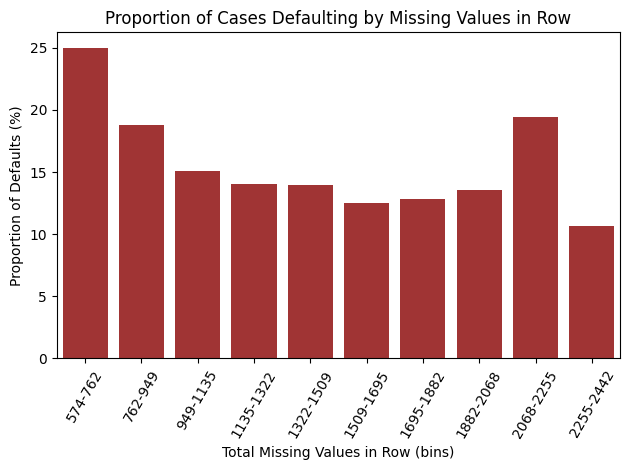

In [42]:
sns.barplot(data=default_counts, x='null_bin', y='pct', color='firebrick')

# Remove decimals in xticks
bins_list = default_counts['null_bin'].unique().tolist()
x_tick_labels = [ f'{int(cat.left)}-{int(cat.right)}' for cat in bins_list ]

plt.xticks(ticks=range(n_bins), labels=x_tick_labels, rotation=60)
plt.xlabel('Total Missing Values in Row (bins)')
plt.ylabel('Proportion of Defaults (%)')
plt.title('Proportion of Cases Defaulting by Missing Values in Row')
plt.tight_layout()
plt.show()

# Save memory
del null_df

#### Removing Columns where Missing data is more than 90% 

In [43]:
# Train and validation data
val_prop = 0.3
val_size = int(len(train_set) * val_prop)
train_size = len(train_set) - val_size
train_df = train_set.iloc[:train_size].copy()
valid_df = train_set.iloc[-val_size:].copy()

# Remove columns with more than 90% missing values
missing_threshold = 0.95
train_df = train_df[train_df.columns[train_set.isnull().mean() < missing_threshold]]

# Remove columns from validation and test
valid_df = valid_df[train_df.columns]
test_df = test_set[train_df.columns].copy()

In [53]:
train_df.shape

(8400, 1877)

In [55]:
(train_df.isnull().mean() < missing_threshold).sum()

1806

In [44]:
# Create X and y
X_train = train_df.drop(columns=['case_id', 'target'])
X_valid = valid_df.drop(columns=['case_id', 'target'])
X_test = test_df.drop(columns=['case_id', 'target'])
y_train = train_df['target']
y_valid = valid_df['target']
y_test = test_df['target']

#### Missing Value Imputation Strategies

1. KNN Imputation:

We will employ KNN imputation, which predicts missing values using the mean or median of the k-nearest neighbors found in the training set. Two configurations will be tested:
    - 5 Neighbors: A tighter cluster which may capture more localized data patterns.
    - 10 Neighbors: A broader cluster to generalize better over the input space.

2. Binary Flag for Missing Values:

Alongside numerical imputation, we will add a binary indicator (flag) for each feature to signal the presence of an imputation. This method helps the model identify patterns associated with the occurrence of missing data.

3. Mean and Median Imputer:

These are straightforward approaches where missing values are replaced with the mean or median of the respective feature. The mean is sensitive to outliers, whereas the median provides a more robust estimate in such cases.

#### Visualization and Evaluation:
1. t-SNE Visualization:

Post-imputation, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize the dataset. This technique will help us observe any distinct patterns or clusters that emerge after imputation, providing insights into how different strategies group the data.

In [45]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

1. KNN Imputation:

In [46]:
# # Fit KNN imputer on training data
# knn_imputer = KNNImputer(n_neighbors=5)
# X_train_knn_imputed_5 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# # Apply KNN imputer to validation data
# X_valid_knn_imputed_5 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

In [47]:
# # Fit KNN imputer on training data
# knn_imputer = KNNImputer(n_neighbors=10)
# X_train_knn_imputed_10 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# # Apply KNN imputer to validation data
# X_valid_knn_imputed_10 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

2. Imputation: Median and Binary flag Indicator for missing values.

In [48]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed = X_train.copy()
X_valid_imputed = X_valid.copy()
X_test_imputed = X_test.copy()

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed[col + '_missing'] = X_train_imputed[col].isna().astype(int)
    X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isna().astype(int)
    X_test_imputed[col + '_missing'] = X_test_imputed[col].isnull().astype(int)

# Impute missing values with median
median_imputer = SimpleImputer(strategy='median')
X_train_imputed[numerical_columns] = median_imputer.fit_transform(X_train_imputed[numerical_columns])
X_valid_imputed[numerical_columns] = median_imputer.transform(X_valid_imputed[numerical_columns])
X_test_imputed[numerical_columns] = median_imputer.transform(X_test_imputed[numerical_columns])

ValueError: Columns must be same length as key

In [49]:
X_train_imputed[numerical_columns].isnull().sum().max()

8400

3. Imputation: Mean and Binary flag Indicator for missing values.

In [100]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed_average = X_train.copy()
X_valid_imputed_average = X_valid.copy()
X_test_imputed_average = X_test.copy()


# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed_average[col + '_missing'] = X_train_imputed_average[col].isnull().astype(int)
    X_valid_imputed_average[col + '_missing'] = X_valid_imputed_average[col].isnull().astype(int)
    X_test_imputed_average[col + '_missing'] = X_test_imputed_average[col].isnull().astype(int)

# Impute missing values with median
mean_imputer = SimpleImputer(strategy='mean')
X_train_imputed_average[numerical_columns] = mean_imputer.fit_transform(X_train_imputed_average[numerical_columns])
X_valid_imputed_average[numerical_columns] = mean_imputer.transform(X_valid_imputed_average[numerical_columns])
X_test_imputed_average[numerical_columns] = mean_imputer.transform(X_test_imputed_average[numerical_columns])

#### Proving More Distinct Patterns Post-Imputation visually with t-SNE

To effectively demonstrate the distinct patterns emerging from different imputation strategies, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding). This technique is particularly valuable for visualizing high-dimensional data in a lower-dimensional space, typically two dimensions, which makes it easier to identify clusters and separations among data points.

For the first graph, as t-SNE does not inherently accommodate missing values. To prepare our dataset for t-SNE visualization:
For categorical features: Convert NaNs to a unique category, ensuring they are treated distinctly during the dimensionality reduction.
For numerical features: Substitute NaNs with a specific numerical value (e.g., -999). This method marks missing entries distinctly, allowing us to observe how t-SNE handles these values compared to the rest of the dataset.


In [101]:
from sklearn.manifold import TSNE

In [102]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def preprocess_and_tsne_with_nan_handling(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
    
    # Handle NaNs in categorical columns
    for column in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna('NULL')  # Replace NaNs with 'NULL'
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    
    # Handle NaNs in numerical columns
    for column in X_encoded.select_dtypes(exclude=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna(-999)  # Replace NaNs with -999
    
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette={0: 'darkblue', 1: 'firebrick'},
        data=tsne_df,
        alpha=0.6

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

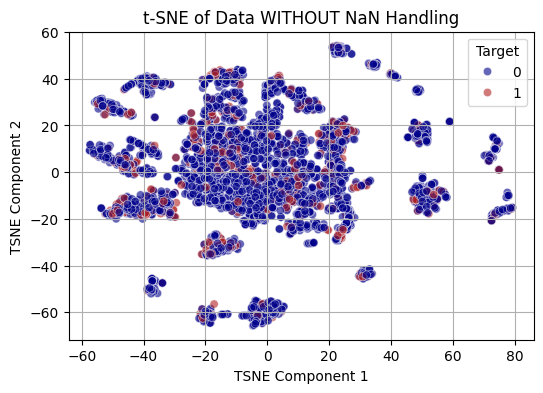

In [103]:
preprocess_and_tsne_with_nan_handling(X_valid, y_valid, 't-SNE of Data WITHOUT NaN Handling')

In [104]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_5, y_valid, 't-SNE of NaN Handling with KNN (5) ')

In [105]:
preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_10, y_valid, 't-SNE of NaN Handling with KNN (10) ')

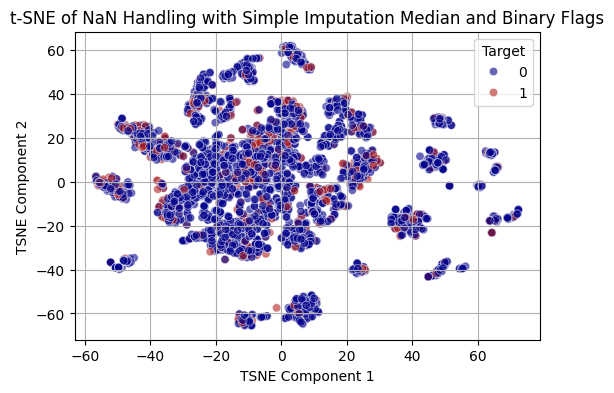

In [106]:
preprocess_and_tsne_with_nan_handling(X_valid_imputed, y_valid, 't-SNE of NaN Handling with Simple Imputation Median and Binary Flags')

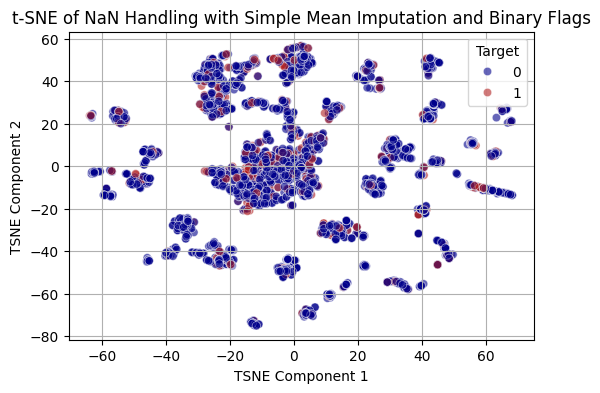

In [107]:
preprocess_and_tsne_with_nan_handling(X_valid_imputed_average, y_valid, 't-SNE of NaN Handling with Simple Mean Imputation and Binary Flags')

## Evaluation

### Model Performance Evaluation:

Following each imputation method, we will retrain our model and evaluate its performance. Key metrics will include accuracy, F1 score, and AUC-ROC, among others. This step is crucial to determine whether the imputation technique enhances the model’s predictive power or detracts from it.

By systematically implementing and comparing these imputation methods, we aim to identify the strategy that most effectively enhances our model's ability to predict true positives, while addressing the challenges posed by missing values in our dataset.

## Conclusion

## Attribution

## Bibliography

## Appendix